In [1]:
import pandas as pd
import numpy as np
import json  # Para parsear .geo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [2]:
# Definir rangos de años
years = range(2000, 2025)  # De 2000 a 2024 inclusive

# Listas para acumular dataframes procesados
modis_list = []
no_incendios_list = []

# Loop para cargar y procesar modis (incendios positivos)
for year in years:
    modis_file = f'Incendios/modis_{year}_Peru.csv'
    if os.path.exists(modis_file):
        modis_df_year = pd.read_csv(modis_file)

        # Filtrar a región de San Martín (ajusta rangos si necesitas precisión)
        san_martin_modis_year = modis_df_year[
            (modis_df_year['latitude'] >= -8) & (modis_df_year['latitude'] <= -5) &
            (modis_df_year['longitude'] >= -78) & (modis_df_year['longitude'] <= -75)
        ].copy() # <-- .copy() evita el warning

        # Agregar label
        san_martin_modis_year['incendio'] = 1

        # Seleccionar columnas relevantes
        san_martin_modis_year = san_martin_modis_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        modis_list.append(san_martin_modis_year)
        # print(f"Cargado y filtrado modis_{year}: {len(san_martin_modis_year)} registros")
    else:
        print(f"Archivo no encontrado: {modis_file}")

# Loop para cargar y procesar no_incendios (negativos)
for year in years:
    no_incendios_file = f'NoIncendios/puntos_sin_incendio_sanmartin_{year}.csv'
    if os.path.exists(no_incendios_file):
        no_incendios_df_year = pd.read_csv(no_incendios_file)

        # Parsear .geo para extraer lon y lat
        no_incendios_df_year['longitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][0])
        no_incendios_df_year['latitude'] = no_incendios_df_year['.geo'].apply(lambda x: json.loads(x)['coordinates'][1])

        # Agregar label
        no_incendios_df_year['incendio'] = 0

        # Seleccionar columnas relevantes
        no_incendios_df_year = no_incendios_df_year[['acq_date', 'latitude', 'longitude', 'incendio']]

        no_incendios_list.append(no_incendios_df_year)
        # print(f"Cargado no_incendios_{year}: {len(no_incendios_df_year)} registros")
    else:
        print(f"Archivo no encontrado: {no_incendios_file}")

# Combinar todos los dataframes
all_modis = pd.concat(modis_list, ignore_index=True) if modis_list else pd.DataFrame()
all_no_incendios = pd.concat(no_incendios_list, ignore_index=True) if no_incendios_list else pd.DataFrame()
full_df = pd.concat([all_modis, all_no_incendios], ignore_index=True)

# Ver totales
print(f"Total incendios: {len(all_modis)}")
print(f"Total no incendios: {len(all_no_incendios)}")
print(f"Dataset completo: {len(full_df)}")
full_df.head()

Total incendios: 75765
Total no incendios: 45314
Dataset completo: 121079


,acq_date,latitude,longitude,incendio
0,2000-11-02,-6.6777,-77.7984,1
1,2000-11-04,-5.8207,-77.3019,1
2,2000-11-04,-6.1100,-77.7796,1
3,2000-11-04,-6.1147,-77.7732,1
4,2000-11-04,-7.4112,-77.6202,1


In [3]:
# Convertir acq_date a datetime (maneja errores si hay formatos inconsistentes)
full_df['acq_date'] = pd.to_datetime(full_df['acq_date'], errors='coerce')

# Eliminar rows con fechas inválidas (si hay NaT)
full_df = full_df.dropna(subset=['acq_date'])

# Extraer features temporales
full_df['year'] = full_df['acq_date'].dt.year
full_df['month'] = full_df['acq_date'].dt.month
full_df['day'] = full_df['acq_date'].dt.day
full_df['day_of_year'] = full_df['acq_date'].dt.dayofyear

# Verificar las nuevas columnas
full_df.head()

,acq_date,latitude,longitude,incendio,year,month,day,day_of_year
0,2000-11-02,-6.6777,-77.7984,1,2000,11,2,307
1,2000-11-04,-5.8207,-77.3019,1,2000,11,4,309
2,2000-11-04,-6.1100,-77.7796,1,2000,11,4,309
3,2000-11-04,-6.1147,-77.7732,1,2000,11,4,309
4,2000-11-04,-7.4112,-77.6202,1,2000,11,4,309


In [4]:
features = ['latitude', 'longitude', 'month', 'day', 'day_of_year', 'year']
X = full_df[features]
y = full_df['incendio']

# Ver balance de clases
print(y.value_counts())

incendio
1    75765
0    45314
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# 1. Crear el escalador
scaler = StandardScaler()

# 2. Ajustarlo (fit) SOLO con los datos de entrenamiento
scaler.fit(X_train)

# 3. Transformar ambos conjuntos (entrenamiento y prueba)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (Opcional) Convertir de nuevo a DataFrame para verlos
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

print("Datos de entrenamiento escalados (ejemplo):")
print(X_train_scaled_df.head())

Datos de entrenamiento escalados (ejemplo):
   latitude  longitude     month       day  day_of_year      year
0  0.218283  -1.009027 -2.265506 -0.332653    -2.289599 -0.190191
1  1.240601   0.442871  0.220444  0.119830     0.227147 -0.335565
2  2.046819   1.036286 -0.844963  1.477281    -0.693330  0.536678
3 -0.437784   0.751470  1.640987 -0.898258     1.543777 -1.643931
4 -0.398681  -0.052817 -2.265506  0.911676    -2.161431  1.699670


In [7]:
# Crear modelo
# Usamos class_weight='balanced' para manejar el desbalance de clases
model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # <-- ¡CAMBIO CLAVE!
    max_iter=1000             # Aumentamos iteraciones para asegurar convergencia
)

# Entrenar el modelo con los datos ESCALADOS
model.fit(X_train_scaled, y_train)

print("Modelo de Regresión Logística entrenado.")

# Predecir en test (también con datos escalados)
y_pred = model.predict(X_test_scaled)

Modelo de Regresión Logística entrenado.


Accuracy: 0.6572514040303932

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.54      0.64      0.58      9063
           1       0.75      0.67      0.71     15153

    accuracy                           0.66     24216
   macro avg       0.65      0.65      0.65     24216
weighted avg       0.67      0.66      0.66     24216


--- Matriz de Confusión ---


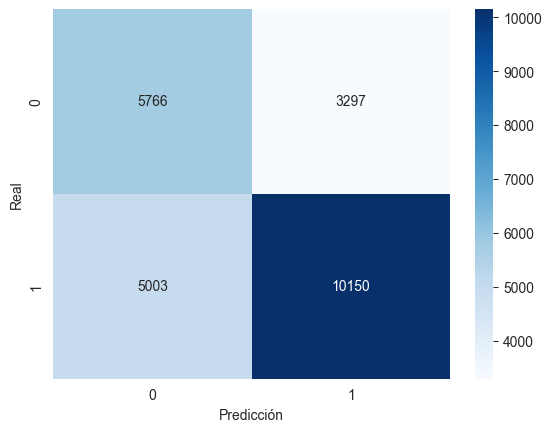


--- Importancia de Features (Coeficientes) ---
             Coefficient
day_of_year     8.829730
longitude       0.139666
year            0.055132
latitude       -0.512047
day            -0.861320
month          -8.349896


C:\Users\User\AppData\Local\Temp\ipykernel_10768\2387152172.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients['Coefficient'], y=coefficients.index, palette='vlag')


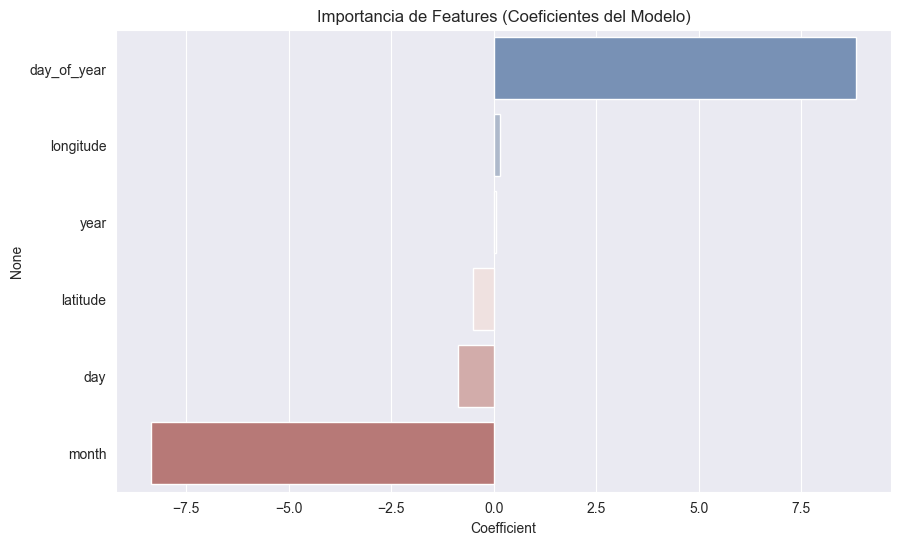

In [8]:
# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# --- Interpretación de Features (Reemplazo de plot_importance) ---
print("\n--- Importancia de Features (Coeficientes) ---")
coefficients = pd.DataFrame(model.coef_[0], index=features, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)

# Gráfico de coeficientes
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients['Coefficient'], y=coefficients.index, palette='vlag')
plt.title('Importancia de Features (Coeficientes del Modelo)')
plt.show()

In [ ]:
# Guardar el modelo
joblib.dump(model, 'logistic_regression_incendios_model.joblib')

# ¡CRÍTICO! Guardar también el escalador
joblib.dump(scaler, 'scaler_incendios.joblib')

print("Modelo de Regresión Logística y Scaler guardados.")